In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# daftar saham idx yg liquid
ticker_list = ['BBRI', 'BBCA', 'BMRI', 'ASII', 'TLKM', 'JSMR', 'INDF', 'UNVR', 'ANTM',
                'BUMI', 'RLCO', 'ADRO', 'TINS', 'MEDC', 'GOTO', 'BRIS', 'NISP', 'PGAS',
                'COAL', 'IHSG', 'SMGR', 'HMSP', 'GGRM', 'ICBP', 'MNCN', 'EXCL', 'WIFI']

idx_tickers = [f'{t}.JK' for t in ticker_list]
print(f"Screening {len(ticker_list)} saham IDX")

Screening 27 saham IDX


In [3]:
end = datetime.now()
start = end - timedelta(days=365)

print(f"Download data {start.date()} - {end.date()}...")
data = yf.download(idx_tickers, start=start, end=end, progress=False)
print(f"Data shape: {data['Close'].shape}")

Download data 2025-01-28 - 2026-01-28...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11688\3348302502.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(idx_tickers, start=start, end=end, progress=False)
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: IHSG.JK"}}}

1 Failed download:
['IHSG.JK']: YFTzMissingError('possibly delisted; no timezone found')


Data shape: (237, 27)


In [4]:
# screening momentum & growth
screen_result = []

for ticker in idx_tickers:
    try:
        sym = ticker.replace('.JK', '')
        close = data['Close'][ticker]
        
        # hitung return berbagai timeframe
        ret_1m = ((close.iloc[-1] - close.iloc[-20]) / close.iloc[-20]) * 100
        ret_3m = ((close.iloc[-1] - close.iloc[-63]) / close.iloc[-63]) * 100
        ret_6m = ((close.iloc[-1] - close.iloc[-126]) / close.iloc[-126]) * 100
        ret_1y = ((close.iloc[-1] - close.iloc[0]) / close.iloc[0]) * 100
        
        # momentum mingguan
        weekly_ret = ((close.iloc[-1] - close.iloc[-5]) / close.iloc[-5]) * 100
        
        # growth score
        growth = (ret_1m + ret_3m + ret_6m) / 3
        
        # volatilitas
        vol = close.pct_change().std() * np.sqrt(252) * 100
        
        # RSI simple
        delta = close.diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        rsi_now = rsi.iloc[-1]
        
        # momentum score
        score = 0
        if weekly_ret > 0:
            score += 1
        if ret_1m > 0:
            score += 1
        if ret_3m > 0:
            score += 1
        if growth > 5:
            score += 1
        if 40 < rsi_now < 70:
            score += 1
        
        screen_result.append({
            'Saham': sym,
            'Harga': close.iloc[-1],
            'Weekly': weekly_ret,
            '1M': ret_1m,
            '3M': ret_3m,
            '1Y': ret_1y,
            'Growth': growth,
            'Vol': vol,
            'RSI': rsi_now,
            'Score': score
        })
    except:
        pass

df_screen = pd.DataFrame(screen_result).sort_values('Score', ascending=False)
print(f"\nScreening selesai. Ditemukan {len(df_screen)} saham valid.")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11688\2119114908.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vol = close.pct_change().std() * np.sqrt(252) * 100
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11688\2119114908.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vol = close.pct_change().std() * np.sqrt(252) * 100



Screening selesai. Ditemukan 27 saham valid.


In [5]:
print("\nTOP MOMENTUM GROWTH SCREENER")
print("="*80)
print(f"{'Saham':<8} {'Weekly':<10} {'1M':<10} {'3M':<10} {'1Y':<10} {'RSI':<8} {'Score':<6}")
print("-"*80)

for idx, row in df_screen.head(15).iterrows():
    saham = row['Saham']
    wk = row['Weekly']
    m1 = row['1M']
    m3 = row['3M']
    y1 = row['1Y']
    rsi = row['RSI']
    sc = row['Score']
    
    print(f"{saham:<8} {wk:+7.1f}% {m1:+7.1f}% {m3:+7.1f}% {y1:+7.1f}% {rsi:6.0f}  {sc:<6}")


TOP MOMENTUM GROWTH SCREENER
Saham    Weekly     1M         3M         1Y         RSI      Score 
--------------------------------------------------------------------------------
ANTM        +4.7%   +33.9%   +40.3%  +232.6%     63  5     
TINS        -7.5%    +3.4%   +38.6%  +249.2%     44  4     
ADRO        -6.0%   +22.8%   +33.8%   +12.7%     62  4     
PGAS        -1.9%   +11.6%   +24.7%   +44.0%     67  4     
MEDC        -0.3%   +11.8%   +16.4%   +50.2%     55  4     
GGRM        -6.1%   +13.8%    +9.7%   +37.5%     51  4     
COAL       -15.1%    -7.1%   +41.1%   +97.5%     44  3     
JSMR        +1.1%    +6.5%    -7.0%   -12.4%     61  3     
HMSP        -0.6%   +11.7%    -3.0%   +46.2%     58  3     
TLKM        -7.2%    -0.6%    +4.2%   +41.8%     47  3     
INDF        +1.5%    +1.1%    -8.1%    -7.0%     57  3     
EXCL       -11.4%    -0.3%   +65.1%   +85.4%     46  3     
NISP        -3.4%    +3.3%    +4.4%   +15.7%     44  3     
BUMI       -15.5%   -19.7%  +122.7%  +14

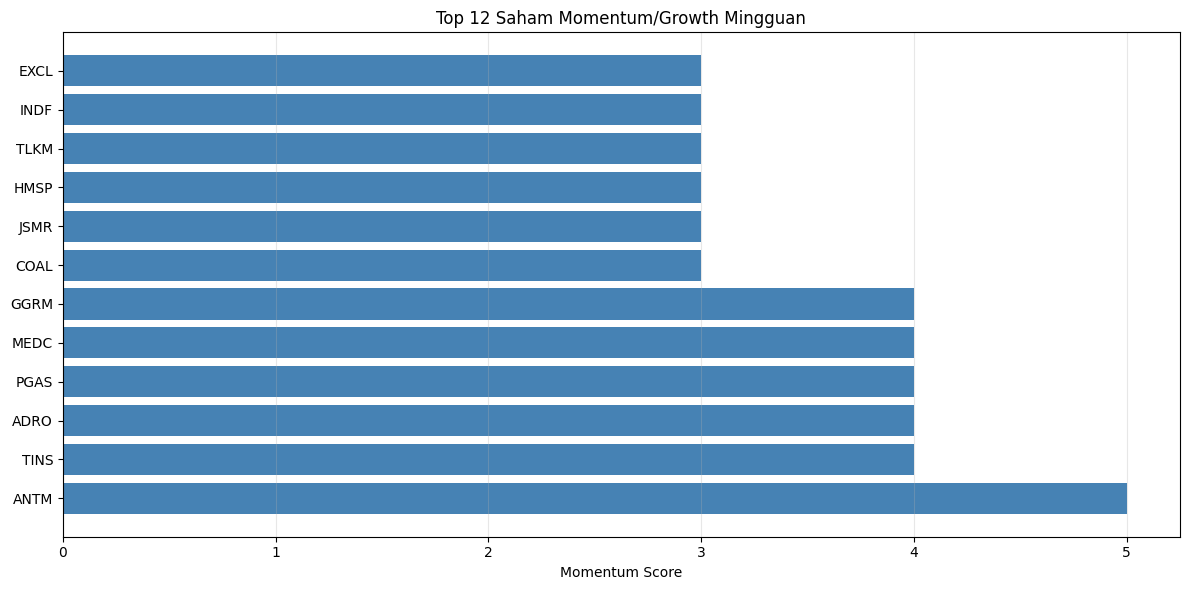

In [6]:
# top performers
top = df_screen.head(12)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top['Saham'], top['Score'], color='steelblue')
ax.set_xlabel('Momentum Score')
ax.set_title('Top 12 Saham Momentum/Growth Mingguan')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

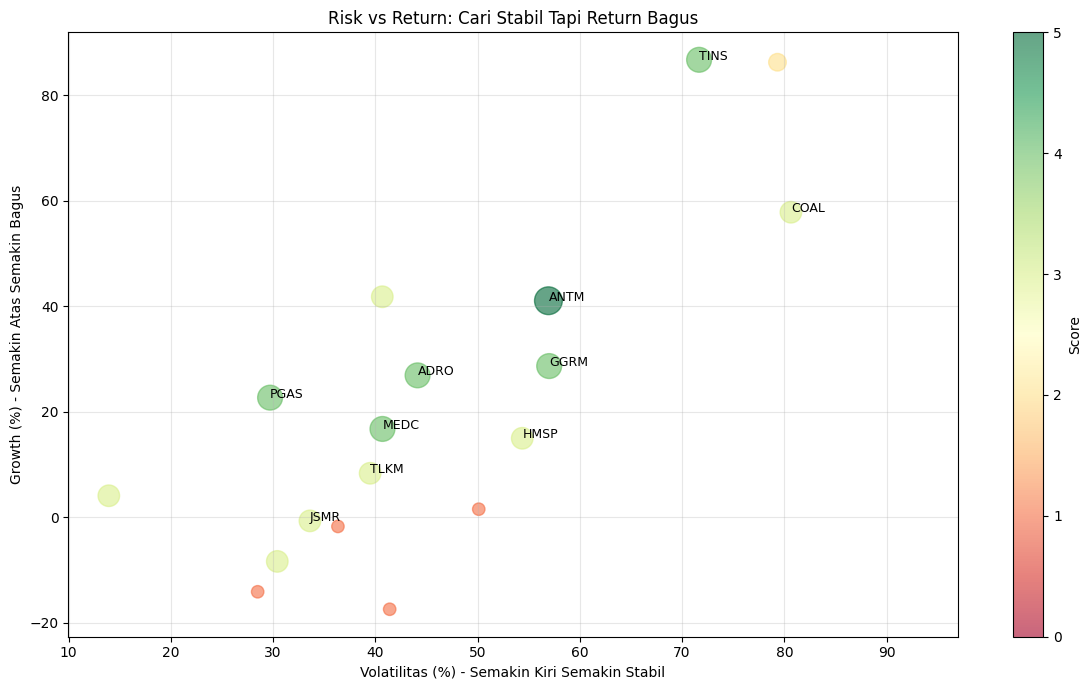

In [7]:
# scatter growth vs volatilitas
fig, ax = plt.subplots(figsize=(12, 7))

scatter = ax.scatter(df_screen['Vol'], df_screen['Growth'], 
                     s=df_screen['Score']*80, alpha=0.6, c=df_screen['Score'], cmap='RdYlGn')

for idx, row in df_screen.head(10).iterrows():
    ax.annotate(row['Saham'], (row['Vol'], row['Growth']), fontsize=9)

ax.set_xlabel('Volatilitas (%) - Semakin Kiri Semakin Stabil')
ax.set_ylabel('Growth (%) - Semakin Atas Semakin Bagus')
ax.set_title('Risk vs Return: Cari Stabil Tapi Return Bagus')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Score')
plt.tight_layout()
plt.show()

In [8]:
# filter: growth bagus, risk terukur
bagus = df_screen[(df_screen['Growth'] > 0) & (df_screen['Vol'] < 50) & (df_screen['Score'] >= 3)]

print("\nSaham dengan Growth Positif + Risk Terukur (Vol < 50%) + Score >= 3:")
print("="*70)
print(f"{'Saham':<8} {'Growth':<10} {'Volatilitas':<15} {'RSI':<8} {'Score':<6}")
print("-"*70)

for idx, row in bagus.iterrows():
    print(f"{row['Saham']:<8} {row['Growth']:+7.1f}% {row['Vol']:7.1f}% {row['RSI']:6.0f}  {row['Score']:<6}")

print(f"\nTotal: {len(bagus)} saham yang layak buy")


Saham dengan Growth Positif + Risk Terukur (Vol < 50%) + Score >= 3:
Saham    Growth     Volatilitas     RSI      Score 
----------------------------------------------------------------------
ADRO       +26.9%    44.1%     62  4     
PGAS       +22.7%    29.7%     67  4     
MEDC       +16.7%    40.7%     55  4     
TLKM        +8.3%    39.5%     47  3     
EXCL       +41.8%    40.7%     46  3     
NISP        +4.1%    13.9%     44  3     

Total: 6 saham yang layak buy
